**One single function**

In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
import pickle

In [3]:
def tune_params(train_X, train_Y, test_X, test_Y, test_signal_x, train_signal_x, test_bkgnd_x, train_bkgnd_x, show_plots=True):
    
    b_par={} #A void dictionary which will contain the best params in each iteration
    
    #TUNING TREES
    #INTIAL MODEL
    model=xgb.XGBClassifier(objective='binary:logistic', 
                        learning_rate=0.2, 
                        max_depth=7,
                        min_child_weight=5,
                        reg_lambda=1010,
                        n_estimators=150)
    
    #NUMBER OF TREES
    eval_set = [(train_X, train_Y), (test_X, test_Y)]
    eval_metric = ["auc","error"]
    %time model.fit(train_X, train_Y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

    # Evaluation results
    evaluation_results = model.evals_result_
    auc_train = evaluation_results["validation_0"]["auc"] # Train ‘auc’ metric
    auc_test = evaluation_results["validation_1"]["auc"] # Test ‘auc’ metric

    if show_plots:
        # Plotting ‘XGBOOST Classification Error’ and ‘XGBOOST Classification AUC’
        plt.figure(figsize=(7,7))
        plt.plot(auc_train)
        plt.plot(auc_test)
        plt.xlabel('Number of trees (n_estimators)')
        plt.ylabel('auc')
        plt.legend(['Train', 'Test'])
        plt.title('XGBoost Classification AUC')
        plt.show()
    
    param_test1 = {
             'n_estimators':[100,150,200]
            }

    gsearch1 = GridSearchCV(estimator = XGBClassifier( objective= 'binary:logistic',
                                                              learning_rate=0.2,
                                                              max_depth=6,
                                                              min_child_weight=2,
                                                              reg_lambda=1010), 

                                     param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

    gsearch1.fit(train_X,train_Y)
    
    b_par['n_estimators']=gsearch1.best_params_['n_estimators']
    
    #DEPTH AND WEIGHT TUNING
    v1=0
    
    param_test2 = {
             'max_depth':[5,6,7],
             'min_child_weight':[4,5,6]
            }

    gsearch2 = GridSearchCV(estimator = XGBClassifier( objective= 'binary:logistic',
                                                              learning_rate=0.2, 
                                                              n_estimators=b_par['n_estimators'], 
                                                              max_depth=6,
                                                              min_child_weight=2,
                                                              reg_lambda=1010), 

                                     param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

    gsearch2.fit(train_X,train_Y)
    #gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_
    v1+=1   
    
    while gsearch2.best_score_ < gsearch1.best_score_ and v1!=3:
        
        param_test2 = {
             'max_depth':[5,6,7],
             'min_child_weight':[4,5,6]
            }

        gsearch2 = GridSearchCV(estimator = XGBClassifier( objective= 'binary:logistic',
                                                              learning_rate=0.2, 
                                                              n_estimators=b_par['n_estimators'] , 
                                                              max_depth=6,
                                                              min_child_weight=2,
                                                              reg_lambda=1010), 

                                     param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

        gsearch2.fit(train_X,train_Y)
        #gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_
        v1+=1
    
    if gsearch2.best_score_ < gsearch1.best_score_:
        b_par['max_depth']=6
        b_par['min_child_weight']=1
        gsearch2.best_score_ = gsearch1.best_score_
        print(b_par)
    else:
        b_par['max_depth']= gsearch2.best_params_['max_depth']
        b_par['min_child_weight']= gsearch2.best_params_['min_child_weight']
            
    #GAMMA TUNING
    v2=0
    
    param_test3 = {
         'gamma':[0.15, 0.1, 0.05, 0]
        }

    gsearch3 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic", 
                                                            learning_rate=0.2,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000
                                                           ),
                                param_grid=param_test3, 
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

    gsearch3.fit(train_X,train_Y)
    #gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_
    v2+=1
    
    while gsearch3.best_score_ < gsearch2.best_score_ and v2!=3:
        param_test3 = {
         'gamma':[0.15, 0.1, 0.05, 0]
        }

        gsearch3 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic", 
                                                            learning_rate=0.2,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000
                                                           ),
                                param_grid=param_test3, 
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

        gsearch3.fit(train_X,train_Y)
        #gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_
        v2+=1
        
    if gsearch3.best_score_ < gsearch2.best_score_:
        b_par['gamma']=0
        gsearch3.best_score_ = gsearch2.best_score
    else:
        b_par['gamma'] = gsearch3.best_params_['gamma']
        
    #SAMPLES TUNING
    v3=0
    
    param_test4 = {
         'subsample':[0.825, 0.85, 0.875, 0.9],
         'colsample_bytree':[0.85, 0.875, 0.9]
        }


    gsearch4 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic", 
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma']
                                                           ),
                                param_grid=param_test4, 
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

    gsearch4.fit(train_X,train_Y)
    #gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_
    v3+=1
        
    while gsearch4.best_score_ < gsearch3.best_score_ and v3!=3:
        param_test4 = {
         'subsample':[0.825, 0.85, 0.875, 0.9],
         'colsample_bytree':[0.85, 0.875, 0.9]
        }


        gsearch4 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic", 
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma']
                                                           ),
                                param_grid=param_test4, 
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

        gsearch4.fit(train_X,train_Y)
        #gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_
        v3+=1
        
    if gsearch4.best_score_ < gsearch3.best_score_:
        b_par['subsample']=1
        b_par['colsample_bytree']=1
        gsearch4.best_score=gsearch3.best_score_
    else:
        b_par['subsample'] = gsearch4.best_params_['subsample']
        b_par['colsample_bytree'] = gsearch4.best_params_['colsample_bytree']
    
    #REGULARIZATION TUNING
    v4=0
    
    param_test6 = {
         'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
         'reg_lambda':[800, 900, 1000, 1100]
        }

    gsearch5 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic", 
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma'],
                                                            subsample=b_par['subsample'],
                                                            colsample_bytree=b_par['colsample_bytree']
                                                           ),
                                param_grid=param_test6, 
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

    gsearch5.fit(train_x,train_y)
    #gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_
    v4+=1   
    
    while gsearch5.best_score_ < gsearch4.best_score_ and v4!=3:
        param_test6 = {
         'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
         'reg_lambda':[800, 900, 1000, 1100]
        }

        gsearch5 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic", 
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma'],
                                                            subsample=b_par['subsample'],
                                                            colsample_bytree=b_par['colsample_bytree']
                                                           ),
                                param_grid=param_test6, 
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

        gsearch5.fit(train_x,train_y)
        #gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_
    
    if gsearch5.best_score_ < gsearch4.best_score_:
        b_par['reg_alpha']=0
        b_par['reg_lambda']=1
        gsearch5.best_score_=gsearch4.best_score_
    else:
        b_par['reg_alpha'] = gsearch5.best_params_['reg_alpha']
        b_par['reg_lambda']= gsearch5.best_params_['reg_lambda']
        
    #STUFF
    model = xgb.XGBClassifier(objective="binary:logistic", 
                                learning_rate=0.2,
                                n_estimators=b_par['n_estimators'],
                                reg_lambda=b_par['reg_lambda'],
                                reg_alpha=b_par['reg_alpha'],
                                max_depth=b_par['max_depth'],
                                min_child_weight=b_par['min_child_weight'],
                                gamma=b_par['gamma'],
                                subsample=b_par['subsample'],
                                colsample_bytree=b_par['colsample_bytree'])
    model.fit(train_X, train_Y)
    
    #CALCULATING PROBABILITIES
    predict_signal_test= model.predict_proba(test_signal_x)[:,1] #Probabilities of being signal or background
    predict_signal_train=model.predict_proba(train_signal_x)[:,1] #Double array of probabilities

    predict_bkgnd_test=model.predict_proba(test_bkgnd_x)[:,1]
    predict_bkgnd_train=model.predict_proba(train_bkgnd_x)[:,1]
    
    #VERIFYING OVERFITTING
    plt.figure(figsize=(10,7))
    plt.title('Signal overfitting')
    m=plt.hist(predict_signal_test, bins=20, label='Test', color='olive')
    n=plt.hist(predict_signal_train, bins=m[1], label='Train', histtype='stepfilled', facecolor='none', edgecolor='red', color='red',
            hatch='///')
    plt.legend(fontsize=13)
    plt.yscale('log')
    
    if show_plots:
        plt.show()
    
    #SIGNAL
    chi2_signal=0
    lista=[]
    
    for i in range(len(m[0])):
        if n[0][i]==0:
            num=0
        else:
            num=((m[0][i]-n[0][i])**2)/n[0][i]
        chi2_signal=chi2_signal+num
        
    chi2_signal=chi2_signal/20
        
    #BKGND
    plt.figure(figsize=(10,7))
    plt.title('Background overfitting')
    m2=plt.hist(predict_bkgnd_test, bins=20, label='Test', color='olive')
    n2=plt.hist(predict_bkgnd_train, bins=m2[1], label='Train', histtype='stepfilled', facecolor='none', edgecolor='red', color='red',
            hatch='///')
    plt.legend(fontsize=13)
    plt.yscale('log')
    
    chi2_bkgnd=0
    for i in range(len(m[0])):
        if n2[0][i]==0:
            num=0
        else:
            num=((m2[0][i]-n2[0][i])**2)/n2[0][i]
        chi2_bkgnd=chi2_bkgnd+num
        
    chi2_bkgnd=chi2_bkgnd/20   
    
    #ROC CURVE
    plt.figure(figsize=(10,7))
    plt.title('ROC curve', fontsize=13)
    model_predict = model.predict_proba(test_X)
    model_predict = model_predict[:,1]
    auc_score_test = roc_auc_score(test_Y, model_predict) 
    fpr, tpr, _ = roc_curve(test_Y, model_predict) #roc_curve(true binary labels, prediction scores)
    print('Test : ', auc_score_test)
    plt.plot(tpr, 1-fpr, label='Test   '+ str(round(auc_score_test, 4)), color='purple')

    model_predict = model.predict_proba(train_X)
    model_predict = model_predict[:,1]
    auc_score_train = roc_auc_score(train_Y, model_predict)
    fpr, tpr, _ = roc_curve(train_Y, model_predict)
    plt.plot(tpr, 1-fpr, label='Train   ' + str(round(auc_score_train, 4)) , color='orange', linewidth=3)
    print('Train : ', auc_score_train)
    plt.legend(fontsize=13)
    plt.ylabel('background rejection', fontsize=13)
    plt.xlabel('Signal efficiency', fontsize=13)
    plt.show()
    
    
    #OVERFITTING AND ROC CURVE
    if (chi2_signal <= 100 and auc_score_train >=0.90):
        print(b_par)
    else:
        print("You should consider repeating this procedure.")
    
    return b_par

In [4]:
def importance(modelo,num, importype):
    """"Recibe modelo y nombre, regresa una gráfica de las features en orden de importancia de menor a mayor\n
        Tiene 5 criterios, el default weight. Los demás son gain,cover, total_gain, total_cover
    """
    
    xgb_fea_imp=pd.DataFrame(list(modelo.get_booster().get_score(importance_type=importype).items()),
    columns=['Caracteristica','importance by:'+str(importype)]).sort_values('importance by:'+str(importype), ascending=False)
    print('',xgb_fea_imp)
    #ax=xgb_fea_imp.plot.hist()    
    xgb_fea_imp.to_csv('xgb_feat_imp'+str(num)+'.csv')

    from xgboost import plot_importance
    
    ax = plot_importance(modelo,importance_type=importype,title='Feature importance by: '+importype )
    ax.figure.savefig('xgb_feat_imp'+str(num)+'by: '+str(importype)+'.png')

def Openfile(nombre,b):
    """La función toma el nombre de un archivo pkl y lo asigna a una variable dataframe de pandas
    Además agrega las etiquetas a la columna
    """
    data=pd.read_pickle(nombre)
    data=data[b]
    return  data
def classification(signal,bkgnd):
    """La función recibe dos dataframes y Clasifica las señales como ruido de fondo con 0 y señal por 1, regresa un dataframe con los 
    datos de ambos dataframes, concatenados"""
    bkgnd['signal/bkgnd'] = 0
    signal['signal/bkgnd'] = 1
    df=pd.concat([signal,bkgnd])
    return df
def sets(df,signal,bkgnd):
    """Recibe los datos del set de señal, fondo y el dataframe concatenado por la función classification\n
    Aplica train_test_split y crea 8 datasets 
    """
    train_x = df.drop(['signal/bkgnd'], axis=1) #features = all minus (signal/bkgnd and masses)
    train_y = df['signal/bkgnd'] 
    
    signal_x = signal.drop(['signal/bkgnd'], axis=1) 
    signal_y = signal['signal/bkgnd']
    
    bkgnd_x = bkgnd.drop(['signal/bkgnd'], axis=1)
    bkgnd_y = bkgnd['signal/bkgnd']

    train_signal_x, test_signal_x, train_signal_y, test_signal_y = train_test_split(signal_x, signal_y, 
                                                  test_size=0.5, 
                                                  random_state=1)
    train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y = train_test_split(bkgnd_x, bkgnd_y, 
                                                      test_size=0.5, 
                                                      random_state=1)
    
    test_x = test_signal_x.append(test_bkgnd_x)
    test_y = test_signal_y.append(test_bkgnd_y)
    
    train_x = train_signal_x.append(train_bkgnd_x)
    train_y = train_signal_y.append(train_bkgnd_y)
    return test_x,test_y,train_x,train_y,train_signal_x, test_signal_x, train_signal_y, test_signal_y,train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y
def prediction(model,test_signal_x,test_signal_y,test_bkgnd_x,test_bkgnd_y,train_signal_x,train_bkgnd_x):
    """Toma los sets obtenidos por la función set y aplica el modelo de clasificación deseado
    regresa cuatro sets con la señales reales y las señales de fondo predichas en sets de entrenamiento y prueba
    """
    predict_signal_test =  model.predict_proba(test_signal_x)[:,1]
    predict_signal_train =  model.predict_proba(train_signal_x)[:,1]
    
    predict_back_test = model.predict_proba(test_bkgnd_x)[:,1]
    predict_back_train = model.predict_proba(train_bkgnd_x)[:,1]
    return predict_signal_test,predict_signal_train,predict_back_test,predict_back_train

def signaloverfit(predict_signal_test,predict_signal_train):
    """Grafica los histogramas de la señal predicha y la señal de entrenamiento para observar si hay overfitting
    en los sets de señales
    """
    plt.figure(figsize=(10,7))
    plt.title('Signal overfit')
    m = plt.hist(predict_signal_test, bins=20, label='Test', color='olive')
    plt.hist(predict_signal_train, bins=m[1], label='Train', 
             histtype='stepfilled', facecolor='none', edgecolor='red',
            hatch='////')
    plt.legend(fontsize=13)
    plt.yscale('log')
    plt.show()
    
def overfitting(predict_signal_test,predict_signal_train,predict_back_test,predict_back_train):
    """"Grafica los sets de señales  y fondo para de prueba y entrenamiento"""
    plt.figure(figsize=(10,7))
    plt.title('Overfitting')
    m = plt.hist(predict_signal_test, bins=20, label='Test Signal', facecolor='lightgreen', edgecolor="darkgreen",
                 histtype='stepfilled', alpha=0.8)
    train = np.histogram(predict_signal_train, bins=m[1])
    bins_ = (train[1][1:]+train[1][:-1])/2
    plt.errorbar(bins_, train[0],yerr=np.sqrt(train[0]), 
                     fmt='s', marker='o' ,color='darkgreen',
                    barsabove=False, capsize=5, label='Train Signal')
    
    plt.hist(predict_back_test, bins=m[1], label='Test Background',
                 histtype='stepfilled', facecolor='none', edgecolor='crimson', hatch= '\\\\', alpha=0.8)
    train2 = np.histogram(predict_back_train, bins=m[1])
    bins_2 = (train2[1][1:]+train2[1][:-1])/2
    plt.errorbar(bins_2, train2[0],yerr=np.sqrt(train[0]), 
                     fmt='s', marker='o' ,color='red',
                    barsabove=False, capsize=5, label='Train Background')
    plt.legend(fontsize=13)
    plt.yscale('log')
    plt.ylim(1, 200000)
    plt.xlim(0, 1)
    plt.ylabel('Events', fontsize=13)
    plt.xlabel('XGBoost output', fontsize=13)
    plt.show()

    
def roc(test_x,test_y,train_x,train_y):
    """"
    Presenta la curva roc, que muestra la precisión del clasificador, entre mas  
    cercana sea el area 1 mejor será el clasificador """
    plt.figure(figsize=(10,7))
    plt.title('ROC curve', fontsize=12)
    model_predict = model.predict_proba(test_x)
    model_predict = model_predict[:,1]
    auc_score = roc_auc_score(test_y, model_predict) 
    fpr, tpr, _ = roc_curve(test_y, model_predict) #roc_curve(true binary labels, prediction scores)
    print('Test : ', auc_score)
    plt.plot(tpr, 1-fpr, label='Test   '+ str(round(auc_score, 4)), color='purple')
    
    model_predict = model.predict_proba(train_x)
    model_predict = model_predict[:,1]
    auc_score = roc_auc_score(train_y, model_predict)
    fpr, tpr, _ = roc_curve(train_y, model_predict)
    plt.plot(tpr, 1-fpr, label='Train   ' + str(round(auc_score,4)) , color='orange', linewidth=3)
    print('Train : ', auc_score)
    plt.legend(loc='best',fontsize=13)
    plt.ylabel('background rejection', fontsize=13)
    plt.xlabel('Signal efficiency', fontsize=13)
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylim(0.7,1)
    plt.show() 

[0]	validation_0-auc:0.68810	validation_0-error:0.23582	validation_1-auc:0.68503	validation_1-error:0.23992
[1]	validation_0-auc:0.70313	validation_0-error:0.23640	validation_1-auc:0.69831	validation_1-error:0.23992
[2]	validation_0-auc:0.72356	validation_0-error:0.23636	validation_1-auc:0.71715	validation_1-error:0.24030
[3]	validation_0-auc:0.72761	validation_0-error:0.23670	validation_1-auc:0.72108	validation_1-error:0.24026
[4]	validation_0-auc:0.74916	validation_0-error:0.23730	validation_1-auc:0.74138	validation_1-error:0.23980
[5]	validation_0-auc:0.75576	validation_0-error:0.23764	validation_1-auc:0.74833	validation_1-error:0.23978
[6]	validation_0-auc:0.75766	validation_0-error:0.23776	validation_1-auc:0.74996	validation_1-error:0.23996
[7]	validation_0-auc:0.76222	validation_0-error:0.23772	validation_1-auc:0.75364	validation_1-error:0.23990
[8]	validation_0-auc:0.76401	validation_0-error:0.23784	validation_1-auc:0.75479	validation_1-error:0.24004
[9]	validation_0-auc:0.76872

[76]	validation_0-auc:0.86620	validation_0-error:0.19940	validation_1-auc:0.84969	validation_1-error:0.20758
[77]	validation_0-auc:0.86650	validation_0-error:0.19842	validation_1-auc:0.84994	validation_1-error:0.20744
[78]	validation_0-auc:0.86683	validation_0-error:0.19846	validation_1-auc:0.85026	validation_1-error:0.20726
[79]	validation_0-auc:0.86713	validation_0-error:0.19770	validation_1-auc:0.85061	validation_1-error:0.20690
[80]	validation_0-auc:0.86743	validation_0-error:0.19734	validation_1-auc:0.85091	validation_1-error:0.20646
[81]	validation_0-auc:0.86772	validation_0-error:0.19708	validation_1-auc:0.85109	validation_1-error:0.20598
[82]	validation_0-auc:0.86790	validation_0-error:0.19698	validation_1-auc:0.85122	validation_1-error:0.20626
[83]	validation_0-auc:0.86832	validation_0-error:0.19640	validation_1-auc:0.85151	validation_1-error:0.20570
[84]	validation_0-auc:0.86845	validation_0-error:0.19600	validation_1-auc:0.85164	validation_1-error:0.20562
[85]	validation_0-a

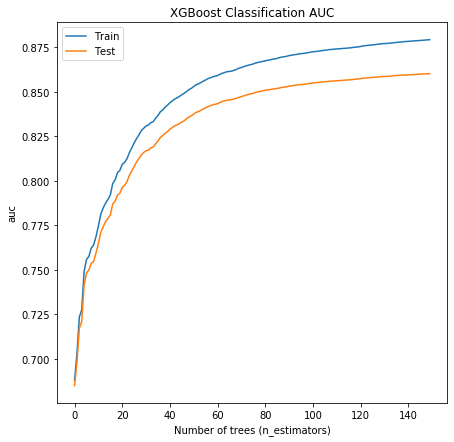

KeyboardInterrupt: 

In [4]:
g=['2_signal.pkl','leftSB_2.pkl']
k=['5_signal.pkl','leftSB_5.pkl']
l=['10_signal.pkl','leftSB_10.pkl']
b=['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']

signal=Openfile(g[0],b)
bkgnd=Openfile(g[1],b)
df=classification(signal,bkgnd)
test_x,test_y,train_x,train_y,train_signal_x, test_signal_x, train_signal_y, test_signal_y,train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y=sets(df,signal,bkgnd)
dict_data_2_signal_left=dict()
dict_data_2_signal_left=tune_params(train_x, train_y, test_x, test_y, test_signal_x, train_signal_x, test_bkgnd_x, train_bkgnd_x, show_plots=True)
pickle.dump( dict_data_2_signal_left, open( "dict_data_2_signal_left.pkl", "wb" ) )

In [14]:
dict_data


{'n_estimators': 200,
 'max_depth': 7,
 'min_child_weight': 4,
 'gamma': 0.15,
 'subsample': 1,
 'colsample_bytree': 1,
 'reg_alpha': 1e-05,
 'reg_lambda': 800}

In [16]:

dict_data


{'n_estimators': 200,
 'max_depth': 7,
 'min_child_weight': 4,
 'gamma': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'reg_alpha': 0.01,
 'reg_lambda': 800}

In [20]:
dict_data

{'n_estimators': 200,
 'max_depth': 7,
 'min_child_weight': 4,
 'gamma': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'reg_alpha': 0.1,
 'reg_lambda': 800}

[0]	validation_0-auc:0.68810	validation_0-error:0.23582	validation_1-auc:0.68503	validation_1-error:0.23992
[1]	validation_0-auc:0.70313	validation_0-error:0.23640	validation_1-auc:0.69831	validation_1-error:0.23992
[2]	validation_0-auc:0.72356	validation_0-error:0.23636	validation_1-auc:0.71715	validation_1-error:0.24030
[3]	validation_0-auc:0.72761	validation_0-error:0.23670	validation_1-auc:0.72108	validation_1-error:0.24026
[4]	validation_0-auc:0.74916	validation_0-error:0.23730	validation_1-auc:0.74138	validation_1-error:0.23980
[5]	validation_0-auc:0.75576	validation_0-error:0.23764	validation_1-auc:0.74833	validation_1-error:0.23978
[6]	validation_0-auc:0.75766	validation_0-error:0.23776	validation_1-auc:0.74996	validation_1-error:0.23996
[7]	validation_0-auc:0.76222	validation_0-error:0.23772	validation_1-auc:0.75364	validation_1-error:0.23990
[8]	validation_0-auc:0.76401	validation_0-error:0.23784	validation_1-auc:0.75479	validation_1-error:0.24004
[9]	validation_0-auc:0.76872

[76]	validation_0-auc:0.86620	validation_0-error:0.19940	validation_1-auc:0.84969	validation_1-error:0.20758
[77]	validation_0-auc:0.86650	validation_0-error:0.19842	validation_1-auc:0.84994	validation_1-error:0.20744
[78]	validation_0-auc:0.86683	validation_0-error:0.19846	validation_1-auc:0.85026	validation_1-error:0.20726
[79]	validation_0-auc:0.86713	validation_0-error:0.19770	validation_1-auc:0.85061	validation_1-error:0.20690
[80]	validation_0-auc:0.86743	validation_0-error:0.19734	validation_1-auc:0.85091	validation_1-error:0.20646
[81]	validation_0-auc:0.86772	validation_0-error:0.19708	validation_1-auc:0.85109	validation_1-error:0.20598
[82]	validation_0-auc:0.86790	validation_0-error:0.19698	validation_1-auc:0.85122	validation_1-error:0.20626
[83]	validation_0-auc:0.86832	validation_0-error:0.19640	validation_1-auc:0.85151	validation_1-error:0.20570
[84]	validation_0-auc:0.86845	validation_0-error:0.19600	validation_1-auc:0.85164	validation_1-error:0.20562
[85]	validation_0-a

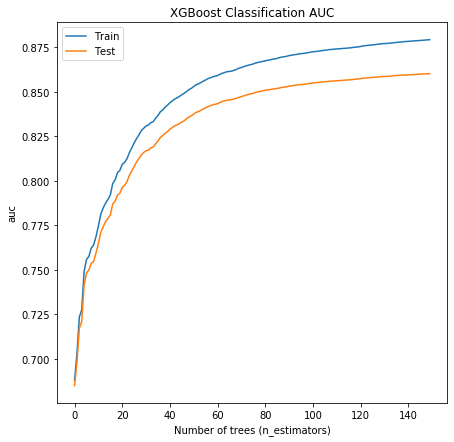

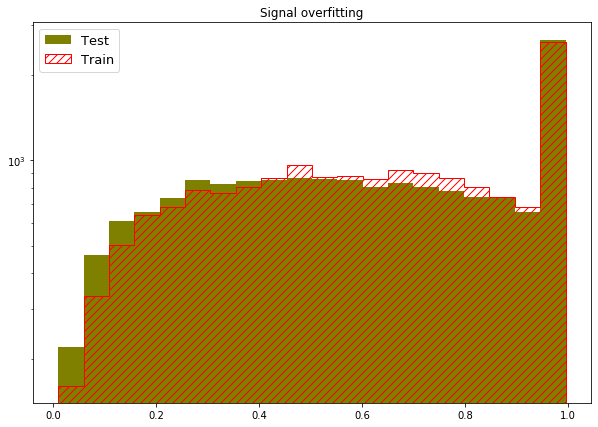

Test :  0.8653100945721163
Train :  0.8864760190171052


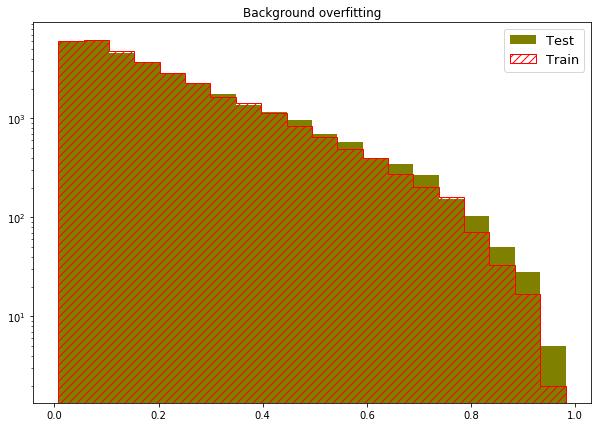

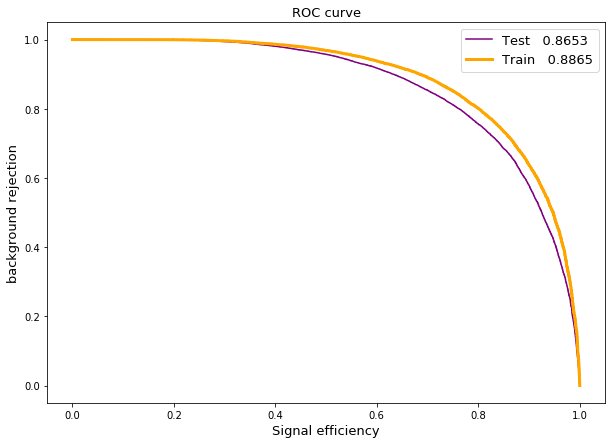

You should consider repeating this procedure.


In [5]:
g=['2_signal.pkl','leftSB_2.pkl']
k=['5_signal.pkl','leftSB_5.pkl']
l=['10_signal.pkl','leftSB_10.pkl']
b=['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']

signal=Openfile(g[0],b)
bkgnd=Openfile(g[1],b)
df=classification(signal,bkgnd)
test_x,test_y,train_x,train_y,train_signal_x, test_signal_x, train_signal_y, test_signal_y,train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y=sets(df,signal,bkgnd)
dict_data_5_signal_left=dict()
dict_data_5_signal_left=tune_params(train_x, train_y, test_x, test_y, test_signal_x, train_signal_x, test_bkgnd_x, train_bkgnd_x, show_plots=True)
pickle.dump( dict_data_5_signal_left, open( "dict_data_5_signal_left.pkl", "wb" ) )

[0]	validation_0-auc:0.61743	validation_0-error:0.07326	validation_1-auc:0.61751	validation_1-error:0.07396
[1]	validation_0-auc:0.63231	validation_0-error:0.07318	validation_1-auc:0.63187	validation_1-error:0.07386
[2]	validation_0-auc:0.63237	validation_0-error:0.07322	validation_1-auc:0.63194	validation_1-error:0.07380
[3]	validation_0-auc:0.63889	validation_0-error:0.07322	validation_1-auc:0.64093	validation_1-error:0.07380
[4]	validation_0-auc:0.65009	validation_0-error:0.07328	validation_1-auc:0.65162	validation_1-error:0.07388
[5]	validation_0-auc:0.65592	validation_0-error:0.07328	validation_1-auc:0.65883	validation_1-error:0.07398
[6]	validation_0-auc:0.66343	validation_0-error:0.07328	validation_1-auc:0.66559	validation_1-error:0.07406
[7]	validation_0-auc:0.67941	validation_0-error:0.07322	validation_1-auc:0.68079	validation_1-error:0.07388
[8]	validation_0-auc:0.68206	validation_0-error:0.07320	validation_1-auc:0.68349	validation_1-error:0.07382
[9]	validation_0-auc:0.68813

[76]	validation_0-auc:0.84967	validation_0-error:0.07226	validation_1-auc:0.81984	validation_1-error:0.07292
[77]	validation_0-auc:0.85043	validation_0-error:0.07224	validation_1-auc:0.82054	validation_1-error:0.07292
[78]	validation_0-auc:0.85140	validation_0-error:0.07224	validation_1-auc:0.82145	validation_1-error:0.07290
[79]	validation_0-auc:0.85203	validation_0-error:0.07226	validation_1-auc:0.82184	validation_1-error:0.07288
[80]	validation_0-auc:0.85232	validation_0-error:0.07218	validation_1-auc:0.82193	validation_1-error:0.07292
[81]	validation_0-auc:0.85265	validation_0-error:0.07216	validation_1-auc:0.82227	validation_1-error:0.07290
[82]	validation_0-auc:0.85321	validation_0-error:0.07214	validation_1-auc:0.82272	validation_1-error:0.07288
[83]	validation_0-auc:0.85379	validation_0-error:0.07214	validation_1-auc:0.82331	validation_1-error:0.07290
[84]	validation_0-auc:0.85477	validation_0-error:0.07214	validation_1-auc:0.82422	validation_1-error:0.07288
[85]	validation_0-a

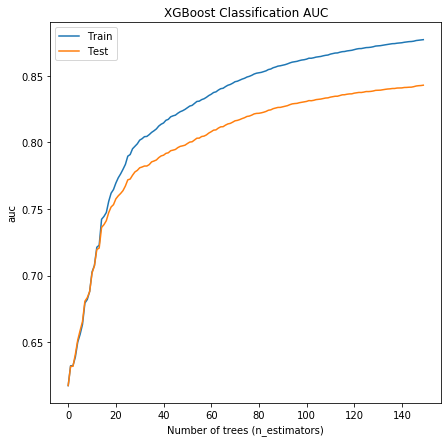

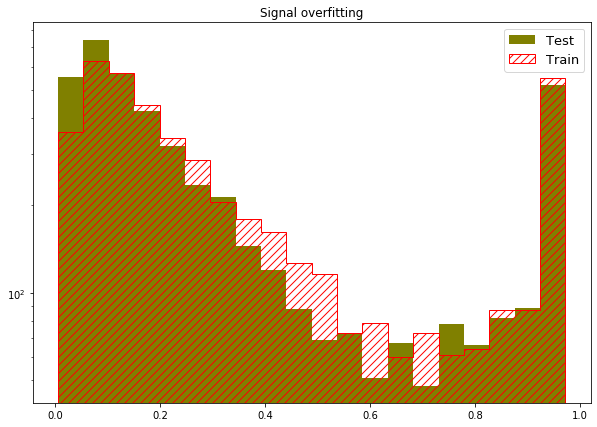

Test :  0.8527861214668936
Train :  0.8921405763139784


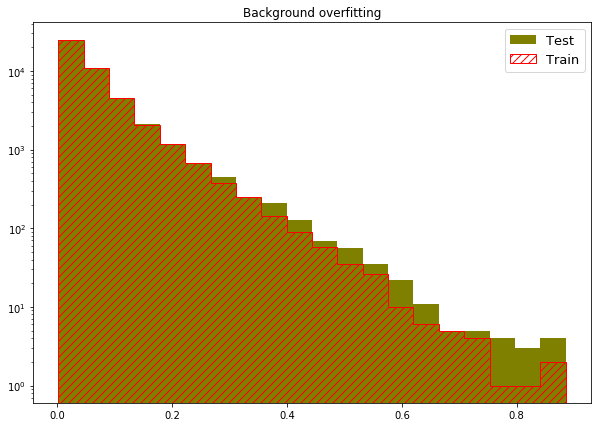

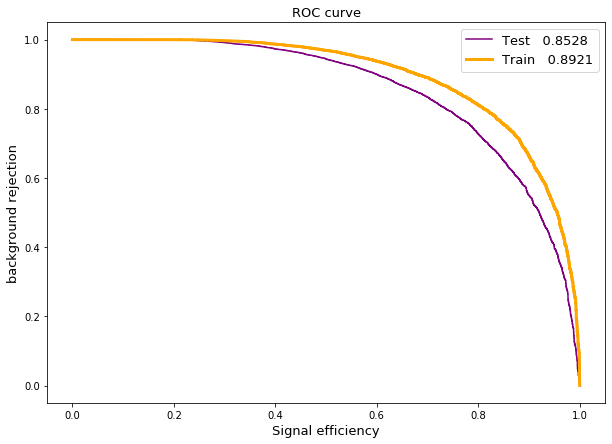

You should consider repeating this procedure.


In [6]:
g=['2_signal.pkl','leftSB_2.pkl']
k=['5_signal.pkl','leftSB_5.pkl']
l=['10_signal.pkl','leftSB_10.pkl']
b=['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']

signal=Openfile(l[0],b)
bkgnd=Openfile(l[1],b)
df=classification(signal,bkgnd)
test_x,test_y,train_x,train_y,train_signal_x, test_signal_x, train_signal_y, test_signal_y,train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y=sets(df,signal,bkgnd)
dict_data_10_signal_left=dict()
dict_data_10_signal_left=tune_params(train_x, train_y, test_x, test_y, test_signal_x, train_signal_x, test_bkgnd_x, train_bkgnd_x, show_plots=True)
pickle.dump( dict_data_10_signal_left, open( "dict_data_10_signal_left.pkl", "wb" ) )

[0]	validation_0-auc:0.88077	validation_0-error:0.03068	validation_1-auc:0.88659	validation_1-error:0.03158
[1]	validation_0-auc:0.90602	validation_0-error:0.03124	validation_1-auc:0.91045	validation_1-error:0.03084
[2]	validation_0-auc:0.91622	validation_0-error:0.03196	validation_1-auc:0.91947	validation_1-error:0.03148
[3]	validation_0-auc:0.92266	validation_0-error:0.03122	validation_1-auc:0.92597	validation_1-error:0.03072
[4]	validation_0-auc:0.93028	validation_0-error:0.03168	validation_1-auc:0.93329	validation_1-error:0.03084
[5]	validation_0-auc:0.93929	validation_0-error:0.03154	validation_1-auc:0.94309	validation_1-error:0.03086
[6]	validation_0-auc:0.94182	validation_0-error:0.03074	validation_1-auc:0.94479	validation_1-error:0.03010
[7]	validation_0-auc:0.94207	validation_0-error:0.03060	validation_1-auc:0.94501	validation_1-error:0.02990
[8]	validation_0-auc:0.94607	validation_0-error:0.03050	validation_1-auc:0.94846	validation_1-error:0.02998
[9]	validation_0-auc:0.95402

[76]	validation_0-auc:0.98466	validation_0-error:0.02206	validation_1-auc:0.98394	validation_1-error:0.02294
[77]	validation_0-auc:0.98472	validation_0-error:0.02198	validation_1-auc:0.98399	validation_1-error:0.02288
[78]	validation_0-auc:0.98483	validation_0-error:0.02200	validation_1-auc:0.98407	validation_1-error:0.02280
[79]	validation_0-auc:0.98486	validation_0-error:0.02200	validation_1-auc:0.98410	validation_1-error:0.02280
[80]	validation_0-auc:0.98497	validation_0-error:0.02194	validation_1-auc:0.98418	validation_1-error:0.02270
[81]	validation_0-auc:0.98500	validation_0-error:0.02184	validation_1-auc:0.98422	validation_1-error:0.02274
[82]	validation_0-auc:0.98511	validation_0-error:0.02176	validation_1-auc:0.98434	validation_1-error:0.02264
[83]	validation_0-auc:0.98517	validation_0-error:0.02166	validation_1-auc:0.98437	validation_1-error:0.02244
[84]	validation_0-auc:0.98527	validation_0-error:0.02168	validation_1-auc:0.98443	validation_1-error:0.02242
[85]	validation_0-a

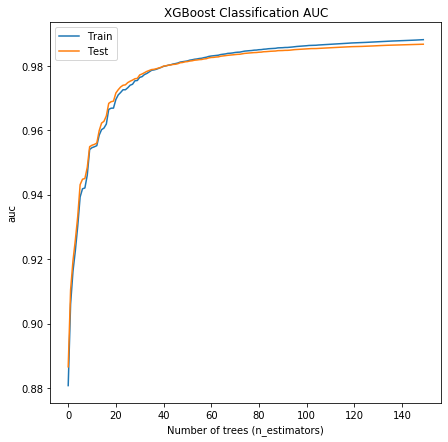

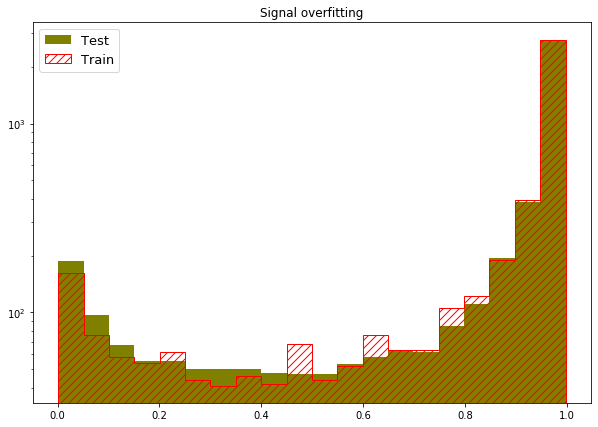

Test :  0.9879258422549959
Train :  0.9903108199234584


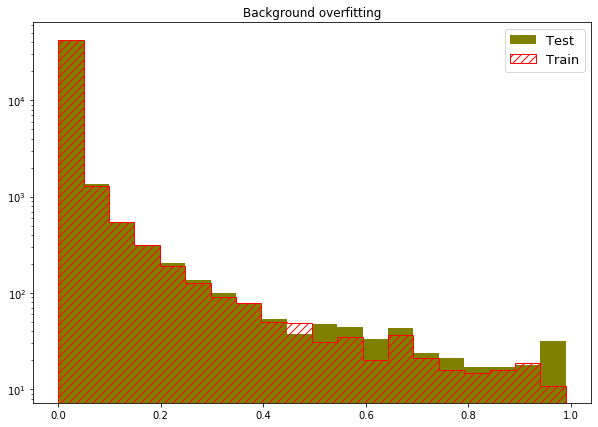

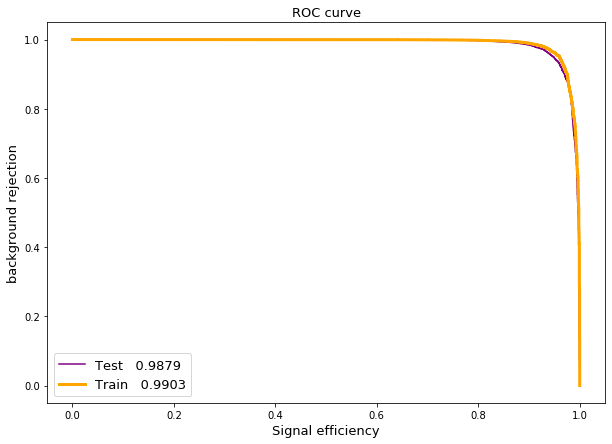

{'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 0, 'subsample': 1, 'colsample_bytree': 1, 'reg_alpha': 0.01, 'reg_lambda': 800}


In [5]:
g=['Signal_2.pkl','leftSB_2.pkl']
k=['Signal_5.pkl','leftSB_5.pkl']
l=['Signal_10.pkl','leftSB_10.pkl']
b=['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']

signal=Openfile(l[0],b)
bkgnd=Openfile(l[1],b)
df=classification(signal,bkgnd)
test_x,test_y,train_x,train_y,train_signal_x, test_signal_x, train_signal_y, test_signal_y,train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y=sets(df,signal,bkgnd)
dict_data_10_signal_left=dict()
dict_data_10_signal_left=tune_params(train_x, train_y, test_x, test_y, test_signal_x, train_signal_x, test_bkgnd_x, train_bkgnd_x, show_plots=True)
pickle.dump( dict_data_10_signal_left, open( "dict_data_10_signal_left.pkl", "wb" ) )

In [7]:
dict_data_10_signal_left


{'n_estimators': 200,
 'max_depth': 7,
 'min_child_weight': 4,
 'gamma': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'reg_alpha': 0.01,
 'reg_lambda': 800}

[0]	validation_0-auc:0.91866	validation_0-error:0.04266	validation_1-auc:0.91534	validation_1-error:0.04568
[1]	validation_0-auc:0.93557	validation_0-error:0.04316	validation_1-auc:0.93366	validation_1-error:0.04616
[2]	validation_0-auc:0.94466	validation_0-error:0.04318	validation_1-auc:0.94254	validation_1-error:0.04572
[3]	validation_0-auc:0.94515	validation_0-error:0.04328	validation_1-auc:0.94327	validation_1-error:0.04530
[4]	validation_0-auc:0.95242	validation_0-error:0.04336	validation_1-auc:0.95085	validation_1-error:0.04548
[5]	validation_0-auc:0.95446	validation_0-error:0.04350	validation_1-auc:0.95297	validation_1-error:0.04608
[6]	validation_0-auc:0.95657	validation_0-error:0.04248	validation_1-auc:0.95458	validation_1-error:0.04554
[7]	validation_0-auc:0.95667	validation_0-error:0.04218	validation_1-auc:0.95469	validation_1-error:0.04520
[8]	validation_0-auc:0.96075	validation_0-error:0.04196	validation_1-auc:0.95922	validation_1-error:0.04500
[9]	validation_0-auc:0.96440

[76]	validation_0-auc:0.98742	validation_0-error:0.03034	validation_1-auc:0.98417	validation_1-error:0.03300
[77]	validation_0-auc:0.98751	validation_0-error:0.03030	validation_1-auc:0.98426	validation_1-error:0.03292
[78]	validation_0-auc:0.98756	validation_0-error:0.03014	validation_1-auc:0.98432	validation_1-error:0.03280
[79]	validation_0-auc:0.98763	validation_0-error:0.03016	validation_1-auc:0.98438	validation_1-error:0.03270
[80]	validation_0-auc:0.98766	validation_0-error:0.03008	validation_1-auc:0.98441	validation_1-error:0.03270
[81]	validation_0-auc:0.98771	validation_0-error:0.03006	validation_1-auc:0.98446	validation_1-error:0.03278
[82]	validation_0-auc:0.98777	validation_0-error:0.03000	validation_1-auc:0.98453	validation_1-error:0.03266
[83]	validation_0-auc:0.98786	validation_0-error:0.02992	validation_1-auc:0.98462	validation_1-error:0.03258
[84]	validation_0-auc:0.98791	validation_0-error:0.02986	validation_1-auc:0.98465	validation_1-error:0.03248
[85]	validation_0-a

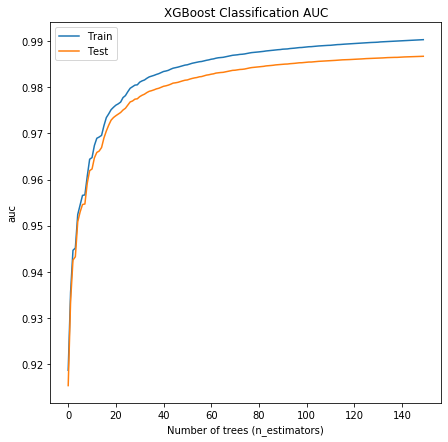

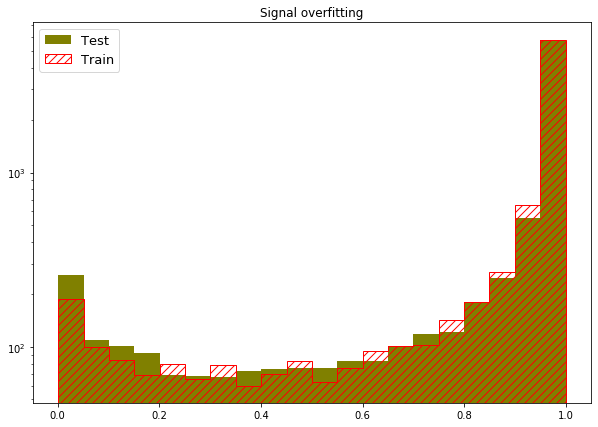

Test :  0.9877392341552412
Train :  0.991725912976422


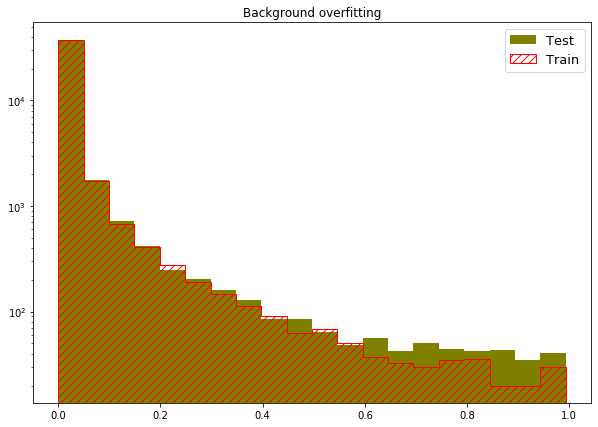

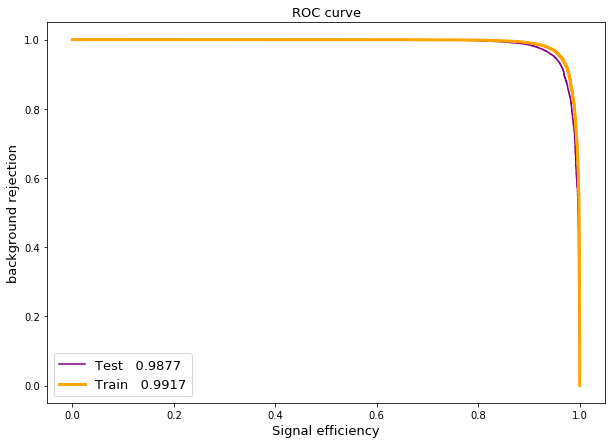

{'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.1, 'subsample': 1, 'colsample_bytree': 1, 'reg_alpha': 0.1, 'reg_lambda': 800}


In [8]:
g=['Signal_2.pkl','leftSB_2.pkl']
k=['Signal_5.pkl','leftSB_5.pkl']
l=['Signal_10.pkl','leftSB_10.pkl']
b=['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']

signal=Openfile(k[0],b)
bkgnd=Openfile(k[1],b)
df=classification(signal,bkgnd)
test_x,test_y,train_x,train_y,train_signal_x, test_signal_x, train_signal_y, test_signal_y,train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y=sets(df,signal,bkgnd)
dict_data_5_signal_left=dict()
dict_data_5_signal_left=tune_params(train_x, train_y, test_x, test_y, test_signal_x, train_signal_x, test_bkgnd_x, train_bkgnd_x, show_plots=True)
pickle.dump( dict_data_5_signal_left, open( "dict_data_5_signal_left.pkl", "wb" ) )

[0]	validation_0-auc:0.94471	validation_0-error:0.05892	validation_1-auc:0.93962	validation_1-error:0.06636
[1]	validation_0-auc:0.95177	validation_0-error:0.05892	validation_1-auc:0.94611	validation_1-error:0.06608
[2]	validation_0-auc:0.95453	validation_0-error:0.06090	validation_1-auc:0.94990	validation_1-error:0.06758
[3]	validation_0-auc:0.95838	validation_0-error:0.06292	validation_1-auc:0.95435	validation_1-error:0.06902
[4]	validation_0-auc:0.96078	validation_0-error:0.06334	validation_1-auc:0.95671	validation_1-error:0.06890
[5]	validation_0-auc:0.96557	validation_0-error:0.06254	validation_1-auc:0.96231	validation_1-error:0.06872
[6]	validation_0-auc:0.96754	validation_0-error:0.06164	validation_1-auc:0.96464	validation_1-error:0.06674
[7]	validation_0-auc:0.96817	validation_0-error:0.06050	validation_1-auc:0.96523	validation_1-error:0.06596
[8]	validation_0-auc:0.96980	validation_0-error:0.06006	validation_1-auc:0.96699	validation_1-error:0.06612
[9]	validation_0-auc:0.97256

[76]	validation_0-auc:0.98785	validation_0-error:0.04346	validation_1-auc:0.98549	validation_1-error:0.04840
[77]	validation_0-auc:0.98790	validation_0-error:0.04336	validation_1-auc:0.98553	validation_1-error:0.04818
[78]	validation_0-auc:0.98797	validation_0-error:0.04324	validation_1-auc:0.98560	validation_1-error:0.04828
[79]	validation_0-auc:0.98802	validation_0-error:0.04304	validation_1-auc:0.98566	validation_1-error:0.04820
[80]	validation_0-auc:0.98809	validation_0-error:0.04298	validation_1-auc:0.98573	validation_1-error:0.04820
[81]	validation_0-auc:0.98815	validation_0-error:0.04296	validation_1-auc:0.98579	validation_1-error:0.04814
[82]	validation_0-auc:0.98820	validation_0-error:0.04288	validation_1-auc:0.98584	validation_1-error:0.04808
[83]	validation_0-auc:0.98823	validation_0-error:0.04286	validation_1-auc:0.98586	validation_1-error:0.04788
[84]	validation_0-auc:0.98828	validation_0-error:0.04278	validation_1-auc:0.98590	validation_1-error:0.04778
[85]	validation_0-a

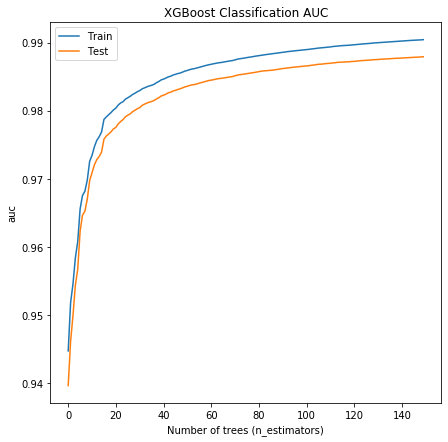

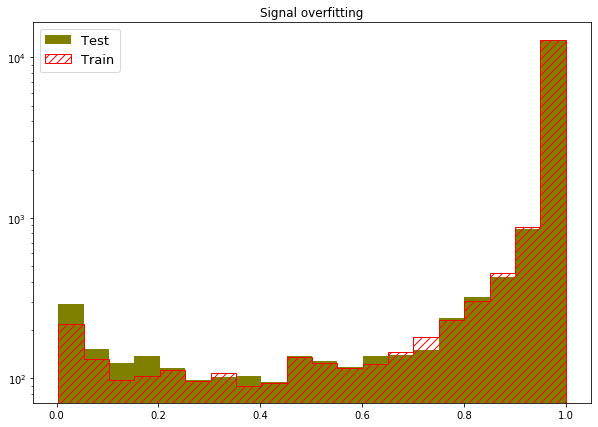

Test :  0.9889537534602563
Train :  0.9916577773205584


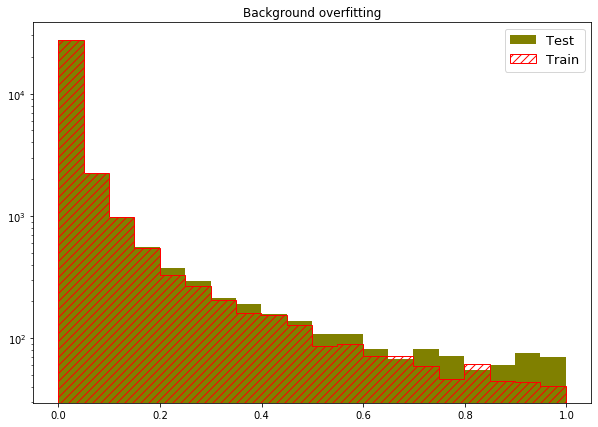

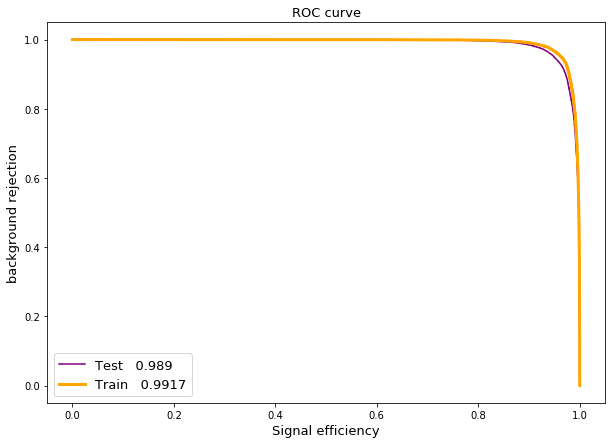

{'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.15, 'subsample': 1, 'colsample_bytree': 1, 'reg_alpha': 0.1, 'reg_lambda': 800}


In [9]:
g=['Signal_2.pkl','leftSB_2.pkl']
k=['Signal_5.pkl','leftSB_5.pkl']
l=['Signal_10.pkl','leftSB_10.pkl']
b=['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']

signal=Openfile(g[0],b)
bkgnd=Openfile(g[1],b)
df=classification(signal,bkgnd)
test_x,test_y,train_x,train_y,train_signal_x, test_signal_x, train_signal_y, test_signal_y,train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y=sets(df,signal,bkgnd)
dict_data_2_signal_left=dict()
dict_data_2_signal_left=tune_params(train_x, train_y, test_x, test_y, test_signal_x, train_signal_x, test_bkgnd_x, train_bkgnd_x, show_plots=True)
pickle.dump( dict_data_2_signal_left, open( "dict_data_2_signal_left.pkl", "wb" ) )

In [10]:
dict_data_2_signal_left


{'n_estimators': 200,
 'max_depth': 7,
 'min_child_weight': 4,
 'gamma': 0.15,
 'subsample': 1,
 'colsample_bytree': 1,
 'reg_alpha': 0.1,
 'reg_lambda': 800}

In [11]:
dict_data_5_signal_left


{'n_estimators': 200,
 'max_depth': 7,
 'min_child_weight': 4,
 'gamma': 0.1,
 'subsample': 1,
 'colsample_bytree': 1,
 'reg_alpha': 0.1,
 'reg_lambda': 800}

In [12]:
dict_data_10_signal_left


{'n_estimators': 200,
 'max_depth': 7,
 'min_child_weight': 4,
 'gamma': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'reg_alpha': 0.01,
 'reg_lambda': 800}

98.03 %


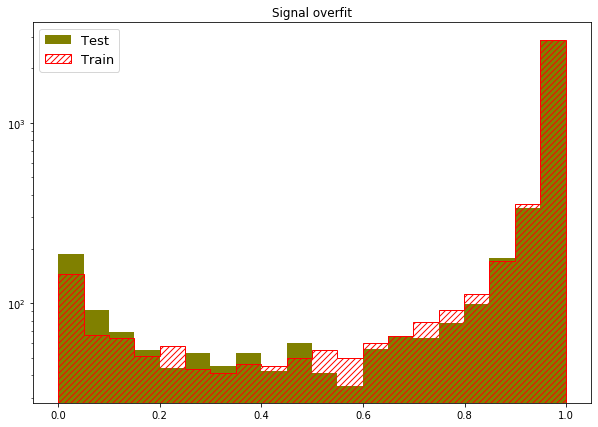

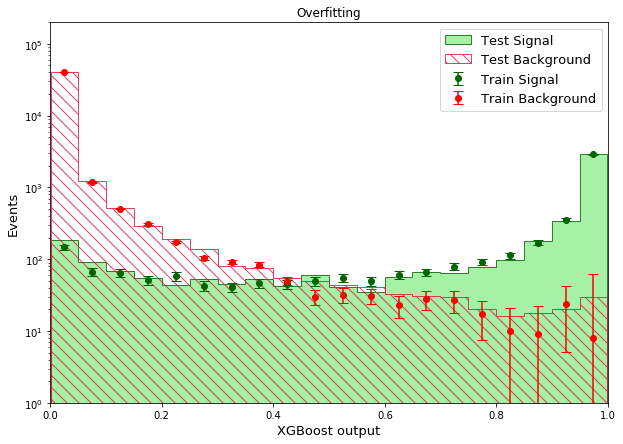

Test :  0.9886260072727036
Train :  0.9916118632587508


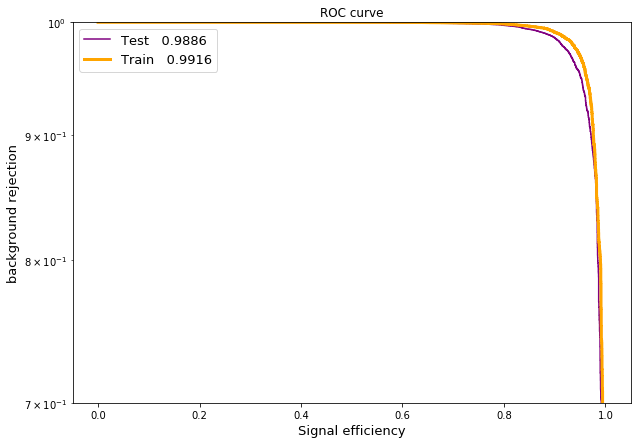

In [13]:
g=['Signal_2.pkl','leftSB_2.pkl']
k=['Signal_5.pkl','leftSB_5.pkl']
l=['Signal_10.pkl','leftSB_10.pkl']
b=['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']
files=[g,k,l]

signal=Openfile(l[0],b)
bkgnd=Openfile(l[1],b)
df=classification(signal,bkgnd)
test_x,test_y,train_x,train_y,train_signal_x, test_signal_x, train_signal_y, test_signal_y,train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y=sets(df,signal,bkgnd)
rocparams=list()

model = xgb.XGBClassifier(objective = 'binary:logistic', 
                          #learning_rate=1    
                          n_estimators= 200,
 max_depth= 7,
 min_child_weight= 4,
 gamma= 0,
 subsample= 1,
 colsample_bytree= 1,
 reg_alpha= 0.01,
 reg_lambda= 800)
model.fit(train_x, train_y)

predict_signal = model.predict(test_x)

predict_signal_test,predict_signal_train,predict_back_test,predict_back_train=prediction(model,test_signal_x,test_signal_y,test_bkgnd_x,test_bkgnd_y,train_signal_x,train_bkgnd_x)
print(np.round(accuracy_score(test_y,predict_signal)*100, 2),'%')

signaloverfit(predict_signal_test,predict_signal_train)
overfitting(predict_signal_test,predict_signal_train,predict_back_test,predict_back_train)
roc(test_x,test_y,train_x,train_y)